# 02 Sales Analysis

This notebook analyzes sales trends, category performance, geographic distribution, and order patterns.

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [2]:
processed_dir = Path("../processed")
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

amazon_sales = pd.read_parquet(processed_dir / "amazon_sales.parquet")
international_sales = pd.read_parquet(processed_dir / "international_sales.parquet")

## Data Preparation

In [3]:
amazon_sales['year'] = pd.to_datetime(amazon_sales['date']).dt.year
amazon_sales['month'] = pd.to_datetime(amazon_sales['date']).dt.month
amazon_sales['year_month'] = pd.to_datetime(amazon_sales['date']).dt.to_period('M')

international_sales['year'] = pd.to_datetime(international_sales['date']).dt.year
international_sales['month'] = pd.to_datetime(international_sales['date']).dt.month

## Sales Trends

### Monthly Sales Analysis

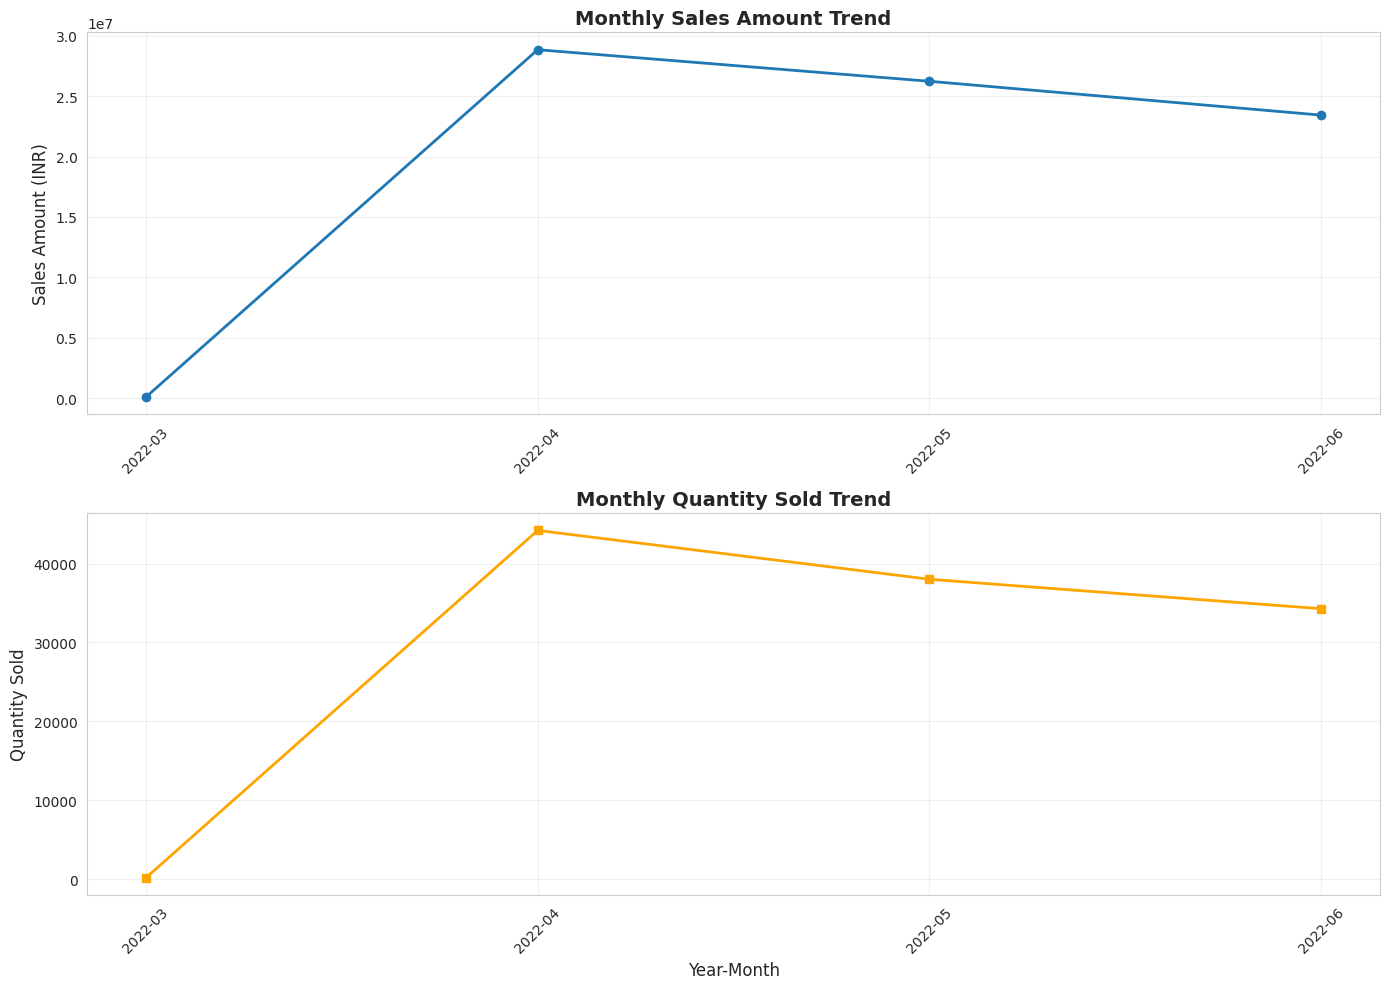

In [4]:
monthly_sales = amazon_sales.groupby('year_month').agg({
    'amount': 'sum',
    'qty': 'sum',
    'Order ID': 'count'
}).reset_index()

monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(monthly_sales['year_month'], monthly_sales['amount'], marker='o', linewidth=2)
axes[0].set_title('Monthly Sales Amount Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales Amount (INR)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly_sales['year_month'], monthly_sales['qty'], marker='s', linewidth=2, color='orange')
axes[1].set_title('Monthly Quantity Sold Trend', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Quantity Sold', fontsize=12)
axes[1].set_xlabel('Year-Month', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'monthly_sales_trends.png', dpi=300, bbox_inches='tight')
plt.show()

### Top Selling Months

In [5]:
top_months = monthly_sales.nlargest(5, 'amount')[['year_month', 'amount', 'qty', 'Order ID']]
top_months = top_months.rename(columns={'Order ID': 'order_count'})
print("Top 5 Sales Months:")
print(top_months.to_string(index=False))

Top 5 Sales Months:
year_month      amount   qty  order_count
   2022-04 28838708.32 44206        49067
   2022-05 26226476.75 38011        42040
   2022-06 23425809.38 34276        37697
   2022-03   101683.85   156          171


## Category Performance

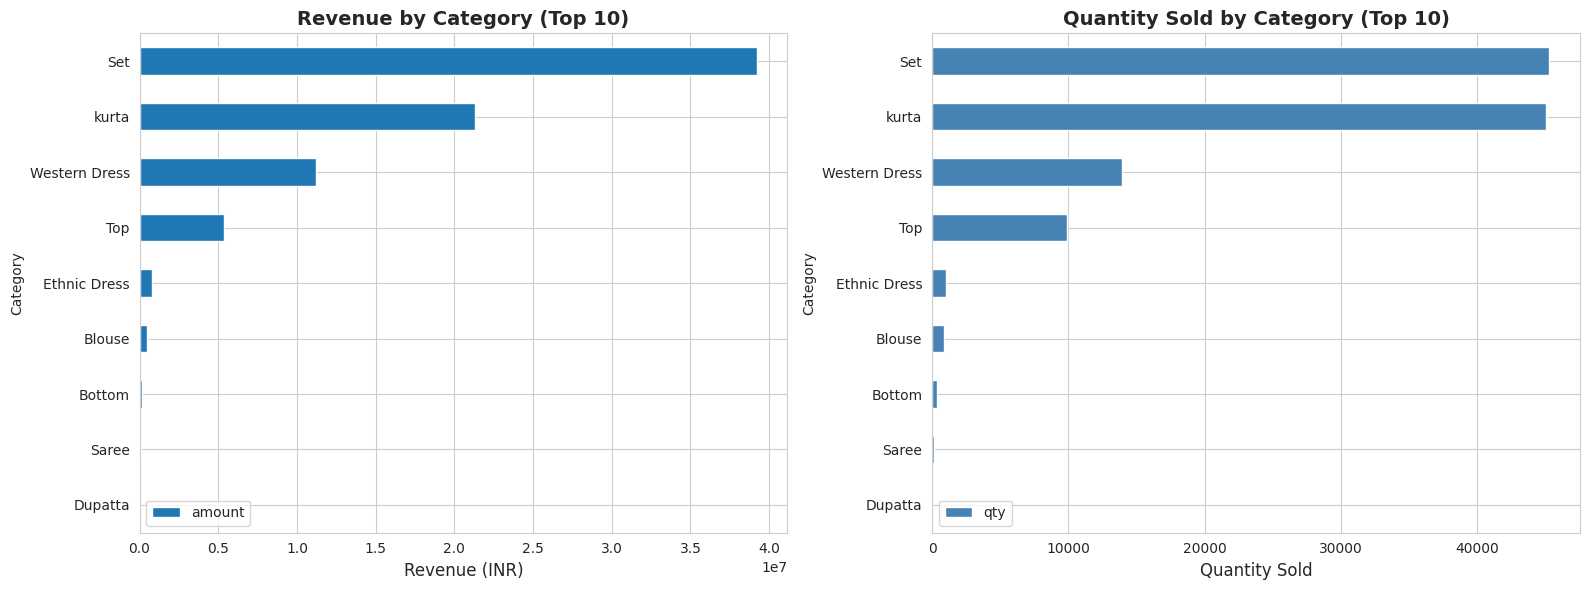

In [6]:
category_sales = amazon_sales.groupby('Category').agg({
    'amount': 'sum',
    'qty': 'sum',
    'Order ID': 'count'
}).sort_values('amount', ascending=False).reset_index()

category_sales = category_sales.rename(columns={'Order ID': 'order_count'})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

category_sales.head(10).plot(kind='barh', x='Category', y='amount', ax=axes[0])
axes[0].set_title('Revenue by Category (Top 10)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue (INR)', fontsize=12)
axes[0].invert_yaxis()

category_sales.head(10).plot(kind='barh', x='Category', y='qty', ax=axes[1], color='steelblue')
axes[1].set_title('Quantity Sold by Category (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quantity Sold', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(output_dir / 'category_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### Category Statistics

In [7]:
print("Category Performance Summary:")
print(category_sales.to_string(index=False))

Category Performance Summary:
     Category      amount   qty  order_count
          Set 39204124.03 45289        50284
        kurta 21299546.70 45045        49877
Western Dress 11216072.69 13943        15500
          Top  5347792.30  9903        10622
 Ethnic Dress   791217.66  1053         1159
       Blouse   458408.18   863          926
       Bottom   150667.98   398          440
        Saree   123933.76   152          164
      Dupatta      915.00     3            3


## Geographic Analysis

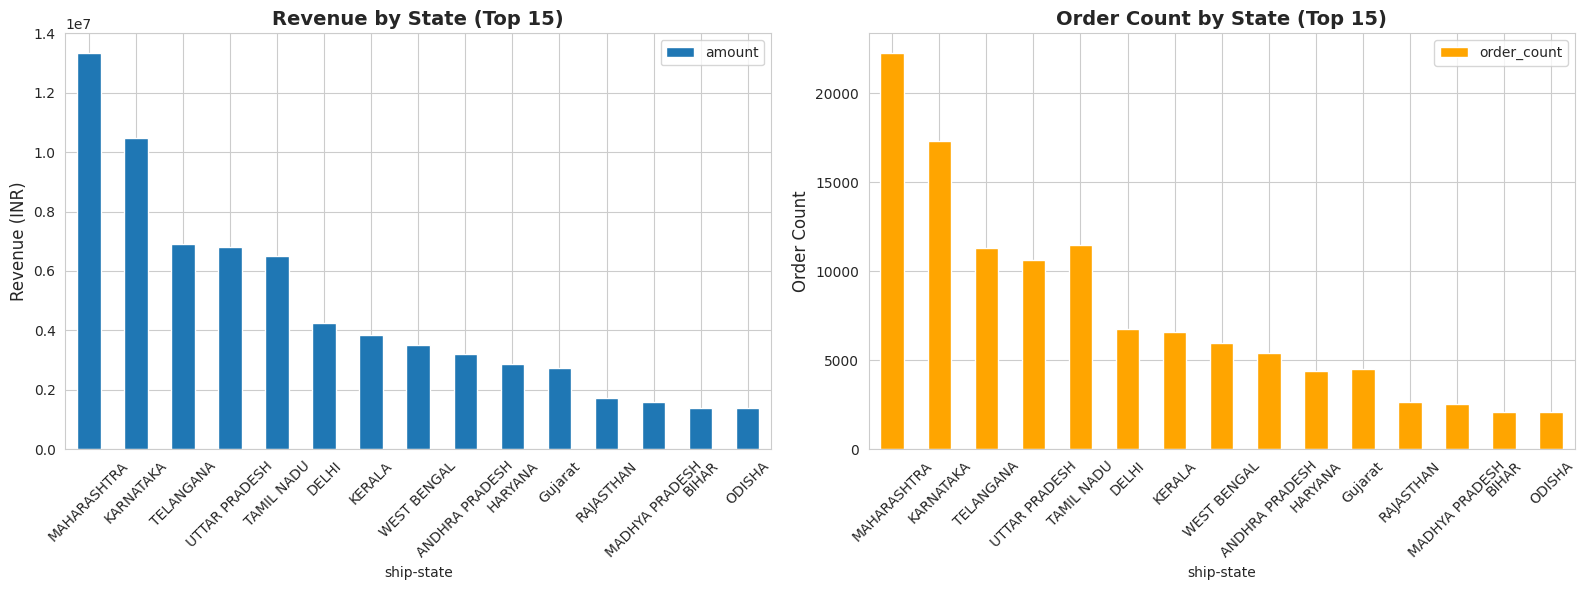

In [8]:
state_sales = amazon_sales.groupby('ship-state').agg({
    'amount': 'sum',
    'Order ID': 'count'
}).sort_values('amount', ascending=False).head(15).reset_index()

state_sales = state_sales.rename(columns={'Order ID': 'order_count'})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

state_sales.plot(kind='bar', x='ship-state', y='amount', ax=axes[0])
axes[0].set_title('Revenue by State (Top 15)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (INR)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

state_sales.plot(kind='bar', x='ship-state', y='order_count', ax=axes[1], color='orange')
axes[1].set_title('Order Count by State (Top 15)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Order Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Order Analysis

### Order Status Distribution

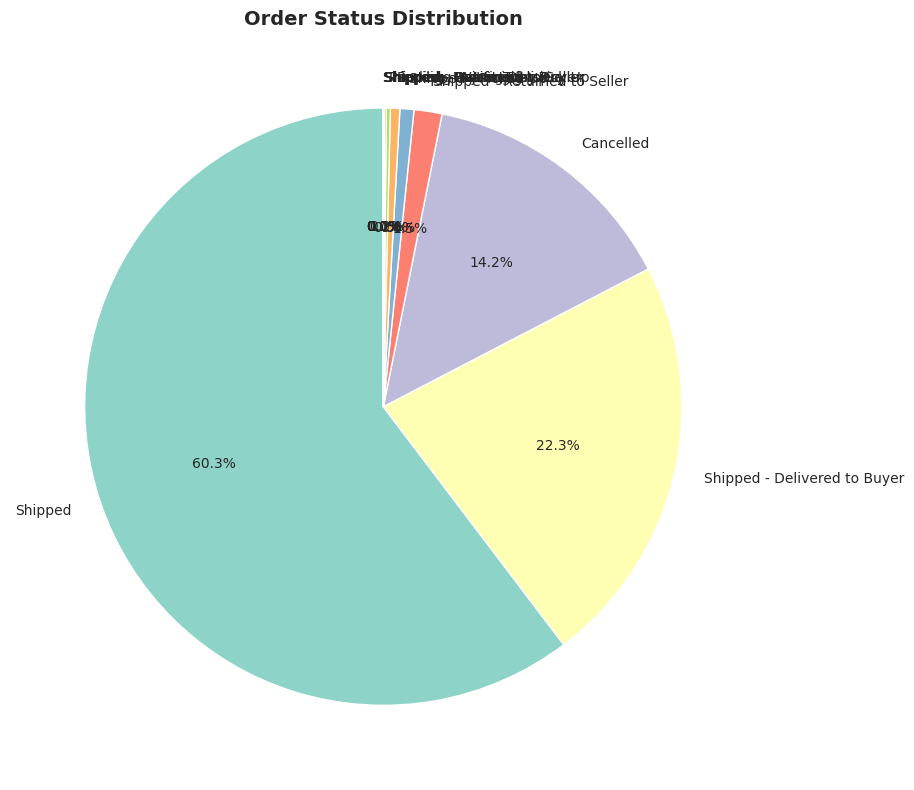

In [9]:
status_counts = amazon_sales['Status'].value_counts()

plt.figure(figsize=(12, 8))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Set3')
plt.title('Order Status Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.savefig(output_dir / 'order_status_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### B2B vs B2C Analysis

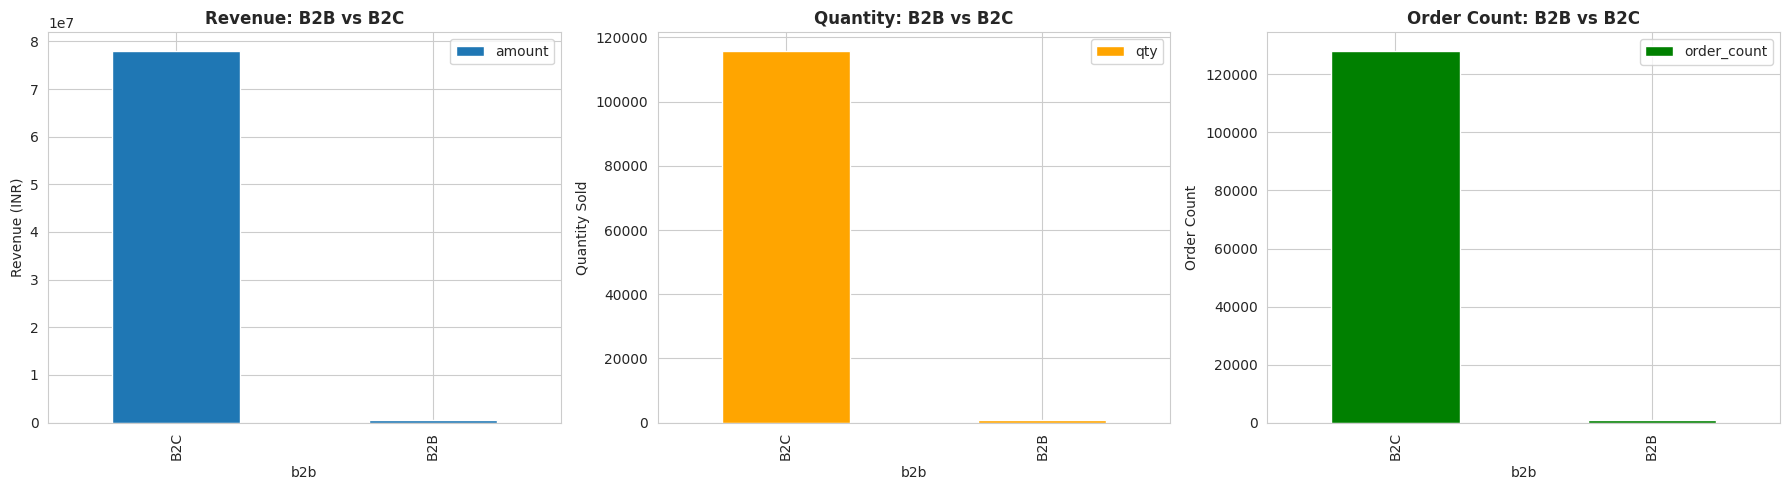

In [10]:
b2b_analysis = amazon_sales.groupby('b2b').agg({
    'amount': 'sum',
    'qty': 'sum',
    'Order ID': 'count'
}).reset_index()

b2b_analysis['b2b'] = b2b_analysis['b2b'].map({True: 'B2B', False: 'B2C'})
b2b_analysis = b2b_analysis.rename(columns={'Order ID': 'order_count'})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

b2b_analysis.plot(kind='bar', x='b2b', y='amount', ax=axes[0])
axes[0].set_title('Revenue: B2B vs B2C', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Revenue (INR)')

b2b_analysis.plot(kind='bar', x='b2b', y='qty', ax=axes[1], color='orange')
axes[1].set_title('Quantity: B2B vs B2C', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Quantity Sold')

b2b_analysis.plot(kind='bar', x='b2b', y='order_count', ax=axes[2], color='green')
axes[2].set_title('Order Count: B2B vs B2C', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Order Count')

plt.tight_layout()
plt.savefig(output_dir / 'b2b_vs_b2c.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary Statistics

In [11]:
print("\n" + "="*60)
print("SALES ANALYSIS SUMMARY")
print("="*60)
print(f"\nTotal Revenue: INR {amazon_sales['amount'].sum():,.2f}")
print(f"Total Quantity Sold: {amazon_sales['qty'].sum():,}")
print(f"Total Orders: {len(amazon_sales):,}")
print(f"Average Order Value: INR {amazon_sales['amount'].mean():,.2f}")
print(f"Average Quantity per Order: {amazon_sales['qty'].mean():.2f}")

print(f"\nTop 3 Categories by Revenue:")
for _, row in category_sales.head(3).iterrows():
    print(f"  - {row['Category']}: INR {row['amount']:,.2f}")


SALES ANALYSIS SUMMARY

Total Revenue: INR 78,592,678.30
Total Quantity Sold: 116,649
Total Orders: 128,975
Average Order Value: INR 648.56
Average Quantity per Order: 0.90

Top 3 Categories by Revenue:
  - Set: INR 39,204,124.03
  - kurta: INR 21,299,546.70
  - Western Dress: INR 11,216,072.69
